In [1]:
from retnet_exp.modeling_retnet import RetNetForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import time
import matplotlib.pyplot as plt

/home/k_ishikawa/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "Spiral-AI/Spiral-RetNet-3b-base"
model_retnet = RetNetForCausalLM.from_pretrained(model_id, device_map="auto")
tok_retnet = AutoTokenizer.from_pretrained(model_id)

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


In [3]:
model_id = "cyberagent/open-calm-3b"
model_transformer = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
tok_transformer = AutoTokenizer.from_pretrained(model_id)

In [4]:
def precompute_kv_retnet(model, inputs):
    with torch.inference_mode():
        start = time.time()
        outputs = model(
            **inputs, return_dict=True, use_cache=True, forward_impl="parallel"
        )
        end = time.time()
        elapsed = end - start
        # print(f"Precompute: {elapsed} seconds")
    return outputs, elapsed

In [5]:
def precompute_kv_transformer(model, inputs):
    with torch.inference_mode():
        start = time.time()
        outputs = model(**inputs, return_dict=True, use_cache=True)
        end = time.time()
        elapsed = end - start
        # print(f"Precompute: {elapsed} seconds")
    return outputs, elapsed

In [6]:
def generate_retnet(
    model, input_ids, precomputed, mode: str, max_new_tokens=50, **kwargs
):
    input_ids = input_ids.to(model.device)
    with torch.inference_mode():
        history = input_ids
        start = time.time()
        if mode == "parallel":
            for _ in range(max_new_tokens):
                outputs = model(
                    input_ids=history,
                    past_key_values=None,
                    return_dict=True,
                    forward_impl="parallel",
                    **kwargs,
                )
                logit = outputs.logits[:, -1, :]  # [batch_size, vocab_size]
                generated = torch.argmax(logit, dim=-1, keepdim=True)
                history = torch.cat([history, generated], dim=-1)

            end = time.time()
            elapsed = end - start
            print(f"Parallel Inference: {elapsed} seconds")
            return history, elapsed

        elif mode == "recurrent":
            past_kv = precomputed.past_key_values
            for _ in range(max_new_tokens):
                outputs = model(
                    input_ids=history,
                    retention_mask=None,
                    forward_impl="recurrent",
                    past_key_values=past_kv,
                    use_cache=True,
                    return_dict=True,
                )
                logit = outputs.logits[:, -1, :]  # [batch_size, vocab_size]
                past_kv = outputs.past_key_values
                generated = torch.argmax(logit, dim=-1, keepdim=True)
                history = torch.cat([history, generated], dim=-1)
            end = time.time()
            elapsed = end - start
            print(f"Reccurent Inference: {elapsed} seconds")
            return history, elapsed

In [7]:
def generate_transformer(model, input_ids, max_new_tokens=50, **kwargs):
    input_ids = input_ids.to(model.device)
    with torch.inference_mode():
        history = input_ids
        start = time.time()
        for _ in range(max_new_tokens):
            outputs = model(input_ids=history, return_dict=True, use_cache=True)
            logit = outputs.logits[:, -1, :]
            generated = torch.argmax(logit, dim=-1, keepdim=True)
            history = torch.cat([history, generated], dim=-1)
        end = time.time()
        elapsed = end - start
        print(f"Transformer Inference: {elapsed} seconds")
        return history, elapsed

In [8]:
def inference_retnet(model, tokenizer, text, mode: str, max_new_tokens=50):
    print()
    print("=" * 80)
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    print("Initial prompt:", len(inputs["input_ids"][0]), "tokens")
    precomputed, precompute_time = precompute_kv_retnet(model, inputs)
    outputs, elapsed = generate_retnet(
        model, inputs["input_ids"], precomputed, mode, max_new_tokens=max_new_tokens
    )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(text) :]
    print("Input:", text)
    print("Output:", generated)
    wps = len(generated) / elapsed
    print(f"Throughput ({mode}): {wps} wps")
    return generated, wps

In [9]:
def inference_transformer(model, tokenizer, text, max_new_tokens=50):
    print()
    print("=" * 80)
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    print("Initial prompt:", len(inputs["input_ids"][0]), "tokens")
    precomputed, precompute_time = precompute_kv_transformer(model, inputs)
    outputs, elapsed = generate_transformer(
        model, inputs["input_ids"], max_new_tokens=max_new_tokens
    )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(text) :]
    print("Input:", text)
    print("Output:", generated)
    wps = len(generated) / elapsed
    print(f"Throughput: {wps} wps")
    return generated, wps

In [10]:
texts = [
    "最近、秋葉原周辺で興味深い",
    """作品は「第一部」「第二部」「間奏曲」「第三部」により構成される[4]。エピグラフとして『三齊紀略』と[5][注 1]、蘇軾の七言律詩『登州海市』の一部「東方海雲空復空／群仙出沒空明中／蕩搖浮世生萬象／豈有貝闕藏珠宮／心知所見皆幻影」が引用されている[3]。

# 画家の澁太吉は、蜃気楼を見に南伊豆の左浦へ出かける。そこで澁は一人の女性と出会い、数日間を共にする中で深い幸福感を得る。しかし、彼女は「安見子」という名前だけを告げ、何も言わずに去って行ってしまった。旅行を終えて帰ってきた澁は、奇跡的に安見子と再会するが、彼女は古くからの親友の妻であったことが判明する[7]。 親友の妻と知っていても尚、澁は安見子への愛情を捨てられずに密会を続け[7]、安見子のほうでも交渉を終わりにしたいと思いつつ、愛を諦められずにいた。やがて澁は安見子に創造の炎をかき立てられ、陥っていたスランプからも脱却する[8]。

# やがて澁は、かねてより別居中であった妻との離婚をも決意する。しかし澁には、かつて別の女性と心中の約束をしながらも裏切った記憶が、今も罪の意識として残っていた。安見子もかつて三角関係があった末に今の夫を選んだのであり、選んだ以上は取り返しがつかないとして、澁と別れようとする。そしてある日突然家出をし、家に戻った後に夫に澁との関係を告白する[7]。澁は、その後再び家を出た安見子と会う約束をするが、息子が腸閉塞で入院して手術を受けることとなり、その約束を破らざるを得なかった。安見子は一人で、最初に澁と出会った左浦へ旅立ち、旅館からの電話で澁を非難することなく、別れの言葉を告げる[7][9]。最初に澁と出会った断崖が、彼女の選んだ死場所だった[10]。

# 登場人物
# 主要人物

# 澁 太吉（しぶ たきち） - 40歳になる抽象画家。姑（澁の母）との折り合いが悪く別居中の妻と、小学生の息子がいる[11]。20歳、30歳、40歳で3人の女を愛したが[9]、ふさちゃんを裏切り、弓子を幸せにできず、安見子との約束をも破る結果に終わった[12]。
# 古賀 安見子（こが やすみこ） - 古賀の妻。かつて野々宮という青年に愛されたこともあったが、彼を振り捨てて古賀と結婚した[13]。名前は『万葉集』の短歌に由来する[3][注 2]。
# 古賀 信介（こが しんすけ） - 大学教授。澁の旧友で、安見子の夫[14]。戦時中に澁がふさちゃんと心中しようとした際、「芸術家としての使命」を自覚させて思い留まらせた[15]。
# 澁 弓子（しぶ ゆみこ） - 澁の妻。かつては画家の菱沼を愛していたが、10年前に彼が渡仏した後に澁の熱心な申し出を受け入れて結婚し、息子の太平をもうける。しかし姑との折り合いが悪く、今は一人で別居して離婚寸前の状況にあり、澁の友人が経営する洋裁店で働いている[15][8]。
# 周辺人物

# 菱沼 五郎（ひしぬま ごろう） - 澁の同級生の画家[15]。かつて弓子が恋していた相手[8]。
# ふさちゃん - 澁と20年前に恋愛関係にあった女学生。澁とは遠縁の関係で、戦時中に聯隊に入った彼が縁故を辿って遊びに行ったことがきっかけで知り合った。勤労奉仕中に健康を害して床に臥せるようになり、最後には病死する[16]。澁は彼女と心中する約束をしていたが、それを裏切って一人だけ死なせる形となった[8]。20年後になってこの恋愛が、澁と弓子の夫婦関係に影を落とすこととなる[16]。
# 構成の特徴
# 本作品は「第一部」「第二部」「間奏曲」「第三部」の内、「間奏曲」以外の各部で、澁が一人称で語る断章と、三人称で会話が中心の断章が交錯する構成となっている。澁の語りでは安見子との出会いとその結末までが時系列順に語られ、三人称の断章では主体が澁と弓子、古賀と安見子、安見子と野々宮、澁とふさちゃん、澁と古賀、弓子と菱沼、といった様々な主体の会話が示される[5]。

# 福永自身は単行本の函に印刷された「著者の言葉」で、「一人の画家を主人公に、恋愛の幾つかの相を描いて、現代における愛の運命を追求した。バッハの「平均率クラヴィア曲集」に倣い、男と女との愛の「平均率」を、「前奏曲」と「フーガ」とを交錯させる形式によって描き出そうと考えた。」と解説している[17]。また、のちに発表した「「海市」の背景」では、以前から2年に1作ほどの割合で『群像』に発表していた短編群の、みな一人の男と女が鍵括弧を使わない言葉で対話を交しているという方式[注 3]を長編に用いたらどういうことになるかと考え、次のように考えたと述べている[18]。本作品は新潮社の「純文学書下ろし特別作品」の一冊として刊行されたが、福永によれば当初は、以前から構想していた別の小説『死の島』をこのシリーズから発表する予定であった。ただ構想が進むにつれ『死の島』の予定枚数が増えていく一方であったため別の小説に替えることとし、編集者の「三百枚でいいですよ、三百枚あれば本になる」という言葉から、福永は新たに400枚程度のものを書くことにした[21]。

# しかし新たな書き下ろし長編小説の構想は中々まとまらなかったため、1964年（昭和39年）4月、福永は一人で伊豆の子浦（静岡県賀茂郡南伊豆町）へと旅行した[注 5]。福永はその8年ほど前に子浦から波勝岬へ出ている遊覧船の船長の家に数日間滞在したことがあり、その際の漁村の印象が鮮明であったためだった。再訪した福永は、妻良に1軒のみある宿屋に約4日滞在し[22]、ここでノートを取っていたが、当初の構想は完成形とは大幅に異なる、「伊豆の漁村を舞台にして二人の男と一人の女との悲劇的な愛を描く」というものだった。また、このときに既に蘇軾の「心知所見皆幻影（まことに知る見るところみな幻影なるを）」という一節を含む詩から、以前の作品『廃市』と対になるのが面白いとして、題名を決めていたという[23]。

# しかし妻良では、折しも同じ宿屋に滞在していた大学の応援団の、浜辺での応援練習や飲み会の大騒ぎにより、小説の案は一向に進まなかった。そこで別の部落の落居へと移った福永は、落居での海を見下ろす風景が非常に気に入り、ここで「恋愛感情は不在の観念から生じるのではないか」と考えたが[22]、浮かんでくる構想は観念的・抽象的なものばかりで、ここでも「仕事はそっちのけにして散歩ばかりしていた」という[23]。

# しかしそれ以降も一向にこの小説は手につかず、翌1965年（昭和40年）の春にようやく書き始め、「それもさんざん手こずった」という[24]。このときに主人公の男を青年から中年にし、小さな子持ちの女の予定だった人物も若い年齢に変更した。その上で二人を、海岸でばったりと出会わせることにした[23]。

# 福永は同年の暮れまでに約380枚を書いたものの、翌1966年（昭和41年）は『死の島』『風のかたみ』という2本の長編の連載が重なり、更に2月から3月までは胃を悪くして入院することとなったため、『海市』は20枚ほどしか進められずに翌年へ持ち越された。1967年（昭和42年）8月1日から9月10日までに、切羽詰まったところで300枚ほどを書き、最終的に当初よりも大幅に分量の増えた700枚で完成させたが、「短い間にこんなに沢山書いたのは私も初めてである」と福永は述懐している[23]。

# 刊行に至ったのは、伊豆への旅行から3年後の1968年（昭和43年）初めとなった[24]。福永は出版後、「しばしば見知らぬ読者から、あの舞台になっている左浦というのは何処ですか、地図を探しても見つからないから」という質問を受けたといい、作中の左浦（さうら）は妻良（めら）、友江は子浦、落人（おちうど）は落居であるが、「半分は想像ですから実物を見るとがっかりしますよ、特に蜃気楼の見える岬なんてのはまったくの創作ですからね」と念を押したという[22][注 6]。

# 福永はのちに「海の想い」と題した随筆で「私は海のほとりで生れたわけでも、また育ったわけでもない。しかし自分でも奇妙に思えるほど、海への想いに取り憑かれていて、それが私の文学的発想の大きな部分を占めていることを否むわけにはいかない」[25]と述べ、また長編小説『風土』を構想していた時から「その小説の人間的葛藤の向う側に、いつでも海が、一種の運命のように横たわっていた。そして私はそれ以来、海を人間の生、或いは人間の死の象徴のように見ることで、小説の発想を促されることがしばしばある」[25]としている。""",
]

In [11]:
for t in texts:
    # inference(model_retnet, tok_retnet, t, "parallel", 100)
    inference_retnet(model_retnet, tok_retnet, t, "recurrent", 100)


Initial prompt: 6 tokens
Reccurent Inference: 38.71298599243164 seconds
Input: 最近、秋葉原周辺で興味深い
Output: イベントが開催されています。
「秋葉原UDX」は、2013年10月1日にオープンした、秋葉原UDXビルの1階部分にある、UDXシアター(旧:UDXシアター)と、UDXシアター(旧:UDXシアター)の2つのシアターからなる施設です。UDXシアターは、2013年10月1日にオープンした、秋葉原UDXビルの1階部分にある、秋葉原UDXビルの1
Throughput (recurrent): 4.365460211026847 wps

Initial prompt: 2120 tokens
Reccurent Inference: 42.54445767402649 seconds
Input: 作品は「第一部」「第二部」「間奏曲」「第三部」により構成される[4]。エピグラフとして『三齊紀略』と[5][注 1]、蘇軾の七言律詩『登州海市』の一部「東方海雲空復空／群仙出沒空明中／蕩搖浮世生萬象／豈有貝闕藏珠宮／心知所見皆幻影」が引用されている[3]。

# 画家の澁太吉は、蜃気楼を見に南伊豆の左浦へ出かける。そこで澁は一人の女性と出会い、数日間を共にする中で深い幸福感を得る。しかし、彼女は「安見子」という名前だけを告げ、何も言わずに去って行ってしまった。旅行を終えて帰ってきた澁は、奇跡的に安見子と再会するが、彼女は古くからの親友の妻であったことが判明する[7]。 親友の妻と知っていても尚、澁は安見子への愛情を捨てられずに密会を続け[7]、安見子のほうでも交渉を終わりにしたいと思いつつ、愛を諦められずにいた。やがて澁は安見子に創造の炎をかき立てられ、陥っていたスランプからも脱却する[8]。

# やがて澁は、かねてより別居中であった妻との離婚をも決意する。しかし澁には、かつて別の女性と心中の約束をしながらも裏切った記憶が、今も罪の意識として残っていた。安見子もかつて三角関係があった末に今の夫を選んだのであり、選んだ以上は取り返しがつかないとして、澁と別れようとする。そしてある日突然家出をし、家に戻った後に夫に澁との関係を告白する[7]。澁は、その後再び家を出た安見子と会う約束

In [12]:
for t in texts:
    inference_transformer(model_transformer, tok_transformer, t, 100)


Initial prompt: 5 tokens
Transformer Inference: 19.441785097122192 seconds
Input: 最近、秋葉原周辺で興味深い
Output: イベントが開催されています。
「秋葉原電気街まつり」
秋葉原電気街振興会が主催し、秋葉原電気街の店舗が協賛する、電気街の秋葉原ならではのお祭りで、今年で4回目。
秋葉原電気街振興会
秋葉原電気街振興会HP
秋葉原電気街振興会HPより
秋葉原電気街振興会HPより
秋葉原電気街振興会HPより
秋葉原電気街振興会HPより
秋葉原電気街振興会HPより
秋葉原電気街振興
Throughput: 9.309844702829883 wps

Initial prompt: 1973 tokens


KeyboardInterrupt: 

In [ ]:
texts = [
    "犬" * 32,
    "犬" * 64,
    "犬" * 128,
    "犬" * 256,
    "犬" * 512,
    "犬" * 1024,
    "犬" * 2048,
    "犬" * 4096,
]

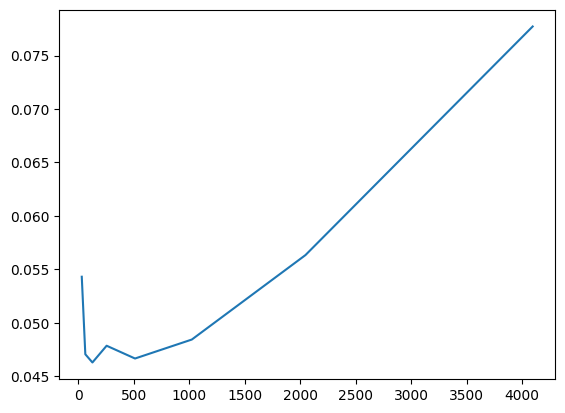

In [ ]:
times_retnet = []
lengths = [32, 64, 128, 256, 512, 1024, 2048, 4096]
for t, l in zip(texts, lengths):
    inputs = tok_retnet(t, return_tensors="pt").to(model_retnet.device)
    kv_retnet, elapsed = precompute_kv_retnet(model_retnet, inputs)
    times_retnet.append({"length": l, "time": elapsed})
plt.plot([t["length"] for t in times_retnet], [t["time"] for t in times_retnet])

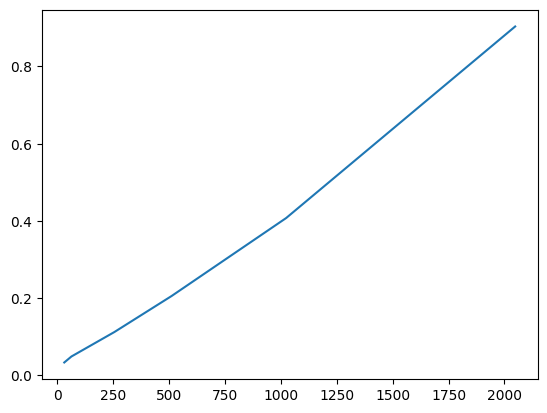

In [ ]:
times_transformer = []
lengths = [32, 64, 128, 256, 512, 1024, 2048]
for t, l in zip(texts, lengths):
    inputs = tok_transformer(t, return_tensors="pt").to(model_transformer.device)
    kv_transformer, elapsed = precompute_kv_transformer(model_transformer, inputs)
    times_transformer.append({"length": l, "time": elapsed})
plt.plot(
    [t["length"] for t in times_transformer], [t["time"] for t in times_transformer]
)

In [ ]:
kv_retnet.past_key_values[0]["prev_key_value"].shape

torch.Size([1, 10, 428, 256])

In [ ]:
kv_transformer.past_key_values[0][1].shape

torch.Size([1, 32, 2048, 80])